In [62]:
import sys 
sys.path.append("../")

import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb

from training import Trainer
from testing import * 
from data.dataprep import DataPrep
from data.utils import sliding_window, win_to_seq
from torch_dvae.measurement_models import * 
from torch_dvae.transition_models import * 
from torch_dvae.encoder_models import * 
from torch_dvae.inference_models import * 
from torch_dvae.initializers import * 
from torch_dvae.DVAE import DVAE 

%matplotlib inline 

In [63]:
sb.set_theme()

In [33]:
PATH = "..\\CMAPSS"
dataset = "FD001"
stride = 1 
T = 40 
split = 0.2 
bs = 250 

prep_class = DataPrep(PATH, dataset)

if dataset == "FD001" or dataset == "FD003":
    prep_class.op_normalize(K=1)    # K=1 normalization, K=6 operating condition norm 
else: 
    prep_class.op_normalize(K=6) 

x_train, y_train, t_train = prep_class.prep_data(prep_class.ntrain, T, stride)
x_test, y_test, t_test = prep_class.prep_test(prep_class.ntest, prep_class.RUL)

x_train, y_train, t_train, x_valid, y_valid, t_valid = prep_class.valid_set(x_train, y_train, t_train, split=split)
train_loader, valid_loader = prep_class.get_dataloaders(bs, x_train, y_train, x_valid, y_valid)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xdim = list(train_loader)[0][0].shape[-1]
zdim = 2 
hdim = 50 
ydim = list(train_loader)[0][1].shape[-1]

x_enc = hdim 
y_enc = hdim 

x_encoder = RNNEncoder(xdim, hdim)
y_encoder = RNNEncoder(ydim, hdim)

initializer = ControlInitializer(hdim, zdim, ydim, xdim)
inference = RNNInference(zdim, hdim, y_enc, x_enc)
transition = MLPTransition(zdim, hdim, 0, x_enc)        # The class automatically ignores y_{1:t-1} by setting ydim=0
measurement = MLPMeasure(ydim, zdim, hdim, 0, x_enc) 

model = DVAE(inference, transition, measurement, y_encoder, x_encoder, initializer).to(device)
trainer = Trainer(lr=1e-3, L2=1e-5)

save_PATH = "saved_models/DVAE_test.pth"

In [35]:
epochs = 200
model = trainer.train_model(epochs, train_loader, valid_loader, model, save_PATH, device)

Epoch 1/200, kl-div: 1.0940, nll: 25204.2017, valid nll: 368.4972, valid RMSE: 99.3435 new best loss, saving model ...
Epoch 10/200, kl-div: 0.0083, nll: 240.1519, valid nll: 240.2317, valid RMSE: 98.4130 new best loss, saving model ...
Epoch 20/200, kl-div: 0.0042, nll: 237.5115, valid nll: 237.9721, valid RMSE: 97.6791 new best loss, saving model ...
Epoch 30/200, kl-div: 0.0027, nll: 236.2698, valid nll: 236.7351, valid RMSE: 96.7142 new best loss, saving model ...
Epoch 40/200, kl-div: 0.0020, nll: 234.7129, valid nll: 235.1691, valid RMSE: 95.3663 new best loss, saving model ...
Epoch 50/200, kl-div: 0.0018, nll: 233.0919, valid nll: 233.4626, valid RMSE: 93.4527 new best loss, saving model ...
Epoch 60/200, kl-div: 0.0018, nll: 231.0980, valid nll: 231.5038, valid RMSE: 90.7669 new best loss, saving model ...
Epoch 70/200, kl-div: 0.0020, nll: 228.3246, valid nll: 228.7414, valid RMSE: 86.9226 new best loss, saving model ...
Epoch 80/200, kl-div: 0.0012, nll: 224.5050, valid nll:

In [36]:
results = test_model(model, x_test, t_test, y_test, T, N=100, device=device)

In [38]:
print("RMSE: ", results["RMSE"])
print("score: ", results["score"])

RMSE:  8.619832
score:  306.2335


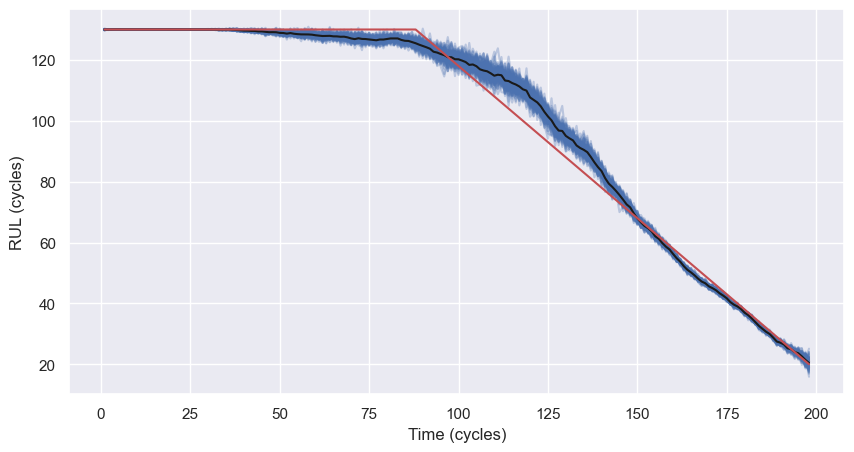

In [72]:
unit = 100 
t = results["times"][unit-1]
y_ests = results["ys"][unit-1][...,0]
y_true = results["y_true"][unit-1][...,0]
y_mean = results["y_mean"][unit-1][...,0]

plt.figure(figsize=(10,5))
plt.plot(t, y_ests.T, color="b", alpha=0.3)
plt.plot(t, y_mean, color="k")
plt.plot(t, y_true, color="r")
plt.xlabel("Time (cycles)")
plt.ylabel("RUL (cycles)")
plt.show()

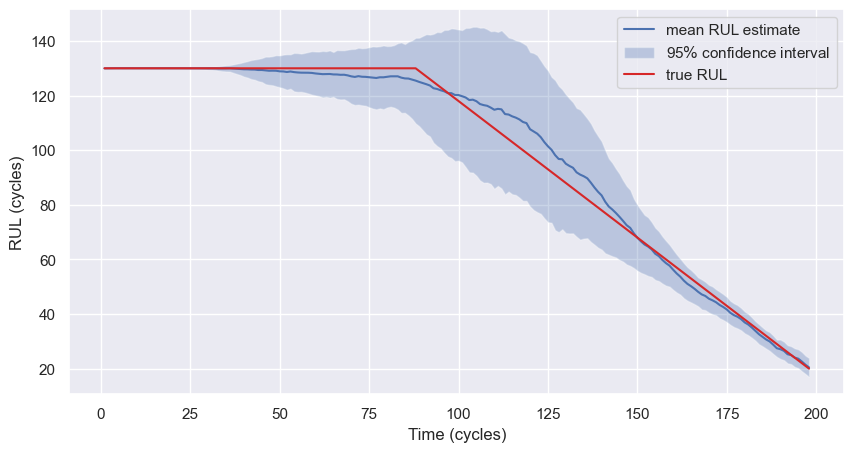

In [71]:
lower_bound = results["y_mean"][unit-1][:,0] - results["y_stds"][unit-1][:,0]*2
upper_bound = results["y_mean"][unit-1][:,0] + results["y_stds"][unit-1][:,0]*2

plt.figure(figsize=(10,5))
plt.plot(t, results["y_mean"][unit-1], label="mean RUL estimate")
plt.fill_between(t, upper_bound, lower_bound, alpha=0.3, label="95$\%$ confidence interval")
plt.plot(t, results["y_true"][unit-1], label="true RUL", color="tab:red")

#plt.title("Unit %i: RUL vs Time"%unit, fontsize=20)
plt.xlabel("Time (cycles)")
plt.ylabel("RUL (cycles)")
plt.legend()
plt.show()

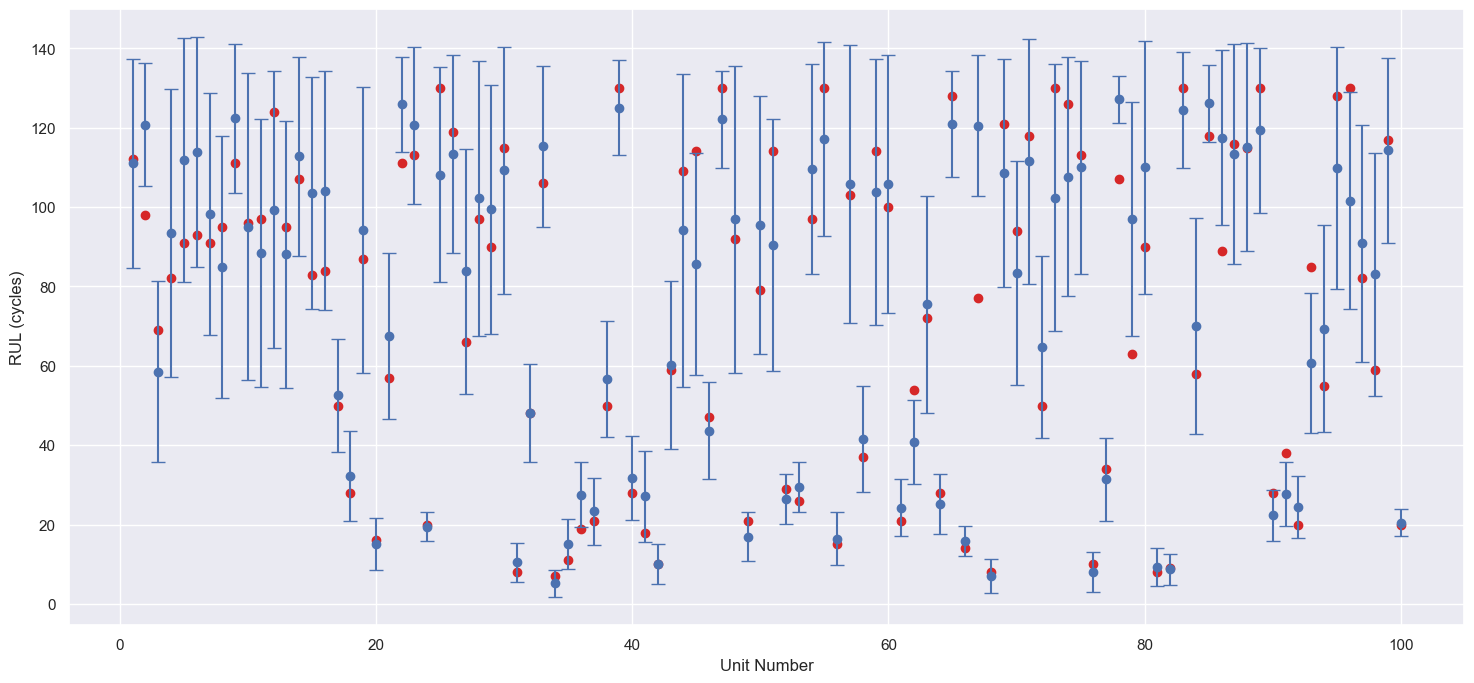

In [70]:
_, r_final, r_fin_est, r_fin_std, max_time = get_final_ruls(results)

units = r_final.shape[0]
unit_list = np.linspace(1, units, units)
bound = 2*r_fin_std

plt.figure(figsize=(18,8))
plt.scatter(unit_list, r_final, marker="o", color="tab:red", label="true")  
plt.errorbar(unit_list, r_fin_est, bound, capsize=5., fmt="o", label="estimates")

plt.xlabel("Unit Number")
plt.ylabel("RUL (cycles)")
plt.show()